This script is used to produce Figure S5 (changes in surface light conditions for different individual model locations) for the Payne et al. paper "End-of-century Arctic Ocean phytoplankton blooms start a month earlier due to anthropogenic climate change". 

1. Import Packages

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import math
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import xesmf as xe

2. Read in 1970, 2020, and 2100 daily light (fswthru and fswdn) and ice (aice) data (these steps takes a while).

In [2]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = ['fswthru_d', 'fswdn_d', 'aice_d']
fswthru_1970 = np.full([50, 365, 384, 320], np.nan)
fswdn_1970 = np.full([50, 365, 384, 320], np.nan)
aice_1970 = np.full([50, 365, 384, 320], np.nan)

for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*19700102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                fswthru_1970[i,t,:,:] = dat[t,:,:]#[t+1825,:,:] 
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        elif j == 1:
            for t in range(0,365):
                fswdn_1970[i,t,:,:] = dat[t,:,:] 
        else:
            for t in range(0,365):
                aice_1970[i,t,:,:] = dat[t,:,:] 

/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswthru_d/b.e21.BHISTsmbb.f09_g17.LE2-1231.017.cice.h1.fswthru_d.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswdn_d/b.e21.BHISTsmbb.f09_g17.LE2-1251.016.cice.h1.fswdn_d.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/aice_d/b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cice.h1.aice_d.19700102-19800101.nc


In [3]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = ['fswthru_d', 'fswdn_d', 'aice_d']
fswthru_2020 = np.full([50, 365, 384, 320], np.nan)
fswdn_2020 = np.full([50, 365, 384, 320], np.nan)
aice_2020 = np.full([50, 365, 384, 320], np.nan)

for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20150101*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                fswthru_2020[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] 
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        elif j == 1:
            for t in range(0,365):
                fswdn_2020[i,t,:,:] = dat[t+1825,:,:] 
        else:
            for t in range(0,365):
                aice_2020[i,t,:,:] = dat[t+1825,:,:] 
        

/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswthru_d/b.e21.BSSP370smbb.f09_g17.LE2-1191.010.cice.h1.fswthru_d.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswdn_d/b.e21.BSSP370smbb.f09_g17.LE2-1281.015.cice.h1.fswdn_d.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/aice_d/b.e21.BSSP370smbb.f09_g17.LE2-1251.020.cice.h1.aice_d.20150101-20250101.nc


In [4]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = ['fswthru_d', 'fswdn_d', 'aice_d']
fswthru_2100 = np.full([50, 365, 384, 320], np.nan)
fswdn_2100 = np.full([50, 365, 384, 320], np.nan)
aice_2100 = np.full([50, 365, 384, 320], np.nan)

for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20950102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                fswthru_2100[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] 
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        elif j == 1:
            for t in range(0,365):
                fswdn_2100[i,t,:,:] = dat[t+1825,:,:] 
        else:
            for t in range(0,365):
                aice_2100[i,t,:,:] = dat[t+1825,:,:] 
        

/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswthru_d/b.e21.BSSP370smbb.f09_g17.LE2-1151.008.cice.h1.fswthru_d.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswdn_d/b.e21.BSSP370smbb.f09_g17.LE2-1151.008.cice.h1.fswdn_d.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/aice_d/b.e21.BSSP370smbb.f09_g17.LE2-1231.015.cice.h1.aice_d.20950102-21001231.nc


3. For the desired location, calculate the proportion of shortwave irradiance that makes it into the surface ocean. 'fswthru' is light that makes it through sea ice, so it is adjusted by the proportion of area covered by sea ice, and 'fswdn' is for the non sea ice-covered area (1-aice).

In [6]:
# i = 322; j = 193; # Bering
# i = 342; j = 194; # Chukchi
i = 341; j = 275; # Hudson
# i = 372; j = 176; # Central

propswi_2100 = np.zeros([50,365]); propswi_2020 = np.zeros([50,365]); propswi_1970 = np.zeros([50,365]); 
propswi_2100 = (fswthru_2100[:,:,i,j]*aice_2100[:,:,i,j] + fswdn_2100[:,:,i,j]*(1-aice_2100[:,:,i,j]))
propswi_2020 = (fswthru_2020[:,:,i,j]*aice_2020[:,:,i,j] + fswdn_2020[:,:,i,j]*(1-aice_2020[:,:,i,j]))
propswi_1970 = (fswthru_1970[:,:,i,j]*aice_2100[:,:,i,j] + fswdn_1970[:,:,i,j]*(1-aice_1970[:,:,i,j]))


4. Plot Figures S5A-D by changing the location.

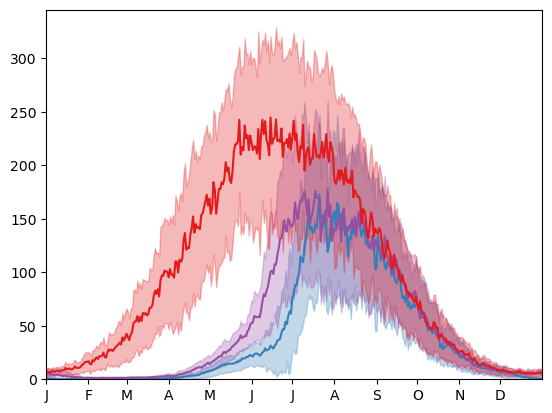

In [16]:
# Set plot colors
rd = '#e41a1c'; pr = '#984ea3'; bl = '#377eb8'

# Calculate mean and St. Dev. for each year.
mean_1970 = np.nanmean(propswi_1970,axis=0); std_1970 = np.nanstd(propswi_1970,axis=0)
mean_2020 = np.nanmean(propswi_2020,axis=0); std_2020 = np.nanstd(propswi_2020,axis=0)
mean_2100 = np.nanmean(propswi_2100,axis=0); std_2100 = np.nanstd(propswi_2100,axis=0)

# Plot mean and St. Dev. for each 
plt.fill_between(np.arange(1,366),mean_1970 - std_1970,mean_1970 + std_1970, color = bl, alpha = 0.3)
plt.fill_between(np.arange(1,366),mean_2020 - std_2020,mean_2020 + std_2020, color = pr, alpha = 0.3)
plt.fill_between(np.arange(1,366),mean_2100 - std_2100,mean_2100 + std_2100, color = rd, alpha = 0.3)
plt.plot(np.arange(1,366),mean_1970, color = bl)
plt.plot(np.arange(1,366),mean_2020, color = pr)
plt.plot(np.arange(1,366),mean_2100, color = rd)

# Set x and y axes.
plt.ylim(0,); plt.xlim(1,366)
plt.xticks([1,32,60,91,121,152,182,213,244,274,305,335], 
           labels = ['J','F','M','A','M','J','J','A','S','O','N','D'])

# print out figure
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/FigS5c.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);


In [ ]:
prop_max_25_1970 = np.zeros([50]); prop_max_25_2020 = np.zeros([50]); prop_max_25_2100 = np.zeros([50]); 
for ens in np.arange(0,50):
    for t in np.arange(0,365):
        if propswi_1970[ens,t] > 4.5:
            prop_max_25_1970[ens] = prop_max_25_1970[ens] + 1
        if propswi_2020[ens,t] > 4.5:
            prop_max_25_2020[ens] = prop_max_25_2020[ens] + 1
        if propswi_2100[ens,t] > 4.5:
            prop_max_25_2100[ens] = prop_max_25_2100[ens] + 1